In [1]:
#Librerias que se utilizaran
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
import lightkurve as lk
import os
import duckdb
import glob
from statsmodels.tsa.seasonal import STL
from astropy.time import Time
from scipy.signal import savgol_filter

In [51]:
!pip install statsmodels

   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.0 MB 3.6 MB/s eta 0:00:03
   ---- ----------------------------------- 1.1/10.0 MB 13.7 MB/s eta 0:00:01
   ----------- ---------------------------- 2.9/10.0 MB 20.8 MB/s eta 0:00:01
   ---------------------- ----------------- 5.6/10.0 MB 29.7 MB/s eta 0:00:01
   --------------------------------- ------ 8.5/10.0 MB 36.2 MB/s eta 0:00:01
   ---------------------------------------  10.0/10.0 MB 37.8 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 33.7 MB/s eta 0:00:00


In [56]:
!pip install astropy

In [2]:
#Estrellas con información sobre sus exoplanetas
Star_info = pd.read_csv('cumulative.csv')
Star_info

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


In [100]:
# División del conjunto de estrellas en 3 lotes
num_stars = len(Star_info)
lotes_stars = num_stars/3
for i in range(3):
    lote = Star_info.loc[i*lotes_stars:(i+1)*lotes_stars]
    lote.to_csv(f'cumulative_{i+1}.csv', index=False)

In [2]:
#Lote de Estrellas con información sobre sus exoplanetas
Star_info = pd.read_csv('cumulative_1.csv')
Star_info

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,3185,6850504,K00070.01,Kepler-20 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-109.0,4.449,0.085,-0.085,0.925,0.101,-0.083,287.69800,42.338718,12.498
3185,3186,3217264,K00401.03,Kepler-149 c,CONFIRMED,CANDIDATE,0.997,0,0,0,...,-107.0,4.462,0.060,-0.090,0.940,0.110,-0.073,285.85367,38.384121,14.001
3186,3187,3342592,K00402.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-210.0,4.485,0.054,-0.216,0.973,0.315,-0.105,291.55630,38.446289,14.923
3187,3188,7440748,K00457.02,Kepler-161 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-101.0,4.550,0.036,-0.050,0.799,0.051,-0.043,290.51648,43.083820,14.196


## Prueba para una sola curva de luz

In [81]:
def DataNormalizado(LC):
    """ La función acepta como entrada la información de una curva de luz (una observación) y extrae el tiempo, el flujo
        y el error del flujo, arreglandolos en un arreglo de un data frame para después normalizar la información del 
        flujo, esto mediante el método básico de normalización, dejando los datos con media 0 y varianza 1"""
    
    DF = pd.DataFrame({'time': LC.time.value,  # Tiempo
                       'flux': LC.flux,  # Flujo
                       'flux_err': LC.flux_err  # Error en el flujo
                         })

    DF["flux"] = DF["flux"].astype(np.float64)
    
    DF["flux"] = (DF["flux"] - np.mean(DF["flux"]))/np.sqrt(np.var(DF["flux"]))
    return DF

In [5]:
help(DataNormalizado)

Help on function DataNormalizado in module __main__:

DataNormalizado(LC)
    La función acepta como entrada la información de una curva de luz (una observación) y extrae el tiempo, el flujo
    y el error del flujo, arreglandolos en un arreglo de un data frame para después normalizar la información del 
    flujo, esto mediante el método básico de normalización, dejando los datos con media 0 y varianza 1



In [82]:
# Busqueda de las observaciones para una estrella en particular
obs = lk.search_lightcurve('Kepler-69', author='Kepler', cadence='long')
# Descarga de las observaciones
lc_nflat = obs.download_all()
# Número de observaciones
N_obs = len(lc_nflat)

#-------------------------------------------------------------------------------------------------------------------------------------------------------
# Unificación de las observaciones
df = pd.DataFrame()
df["time"] = []
df["flux"] = []
df["flux_err"] = []
for i in range(N_obs):
    Lc_tem = DataNormalizado(lc_nflat[i])
    df = pd.concat([df,Lc_tem],ignore_index=True)

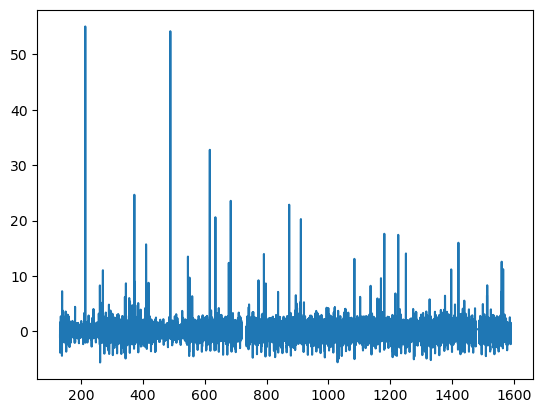

In [83]:
plt.plot(df["time"],df["flux"])
plt.show()

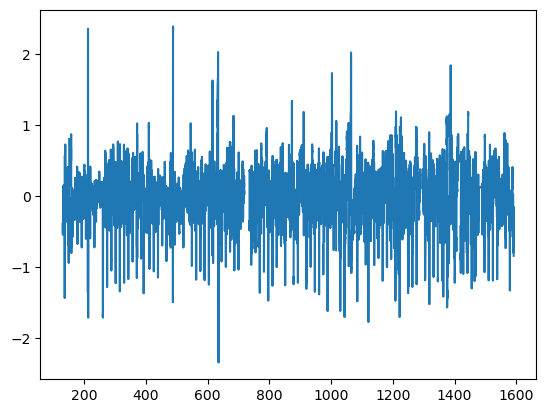

In [88]:
# Código guía para eliminar tendencia con filtros de Savitzky-Golay
flux = savgol_filter(df['flux'], window_length=51, polyorder=3)
plt.plot(df["time"],flux)
plt.show()

## Obtención de las curvas de luz por estrella 

In [3]:
url_LC = "../Curvas_de_luz/"

In [4]:
def DataNormalizado(LC):
    DF = pd.DataFrame({'time': LC.time.value,  # Tiempo
                       'flux': LC.flux,  # Flujo
                       'flux_err': LC.flux_err  # Error en el flujo
                         })
    
    DF["flux"] = DF["flux"].astype(np.float64)
    
    DF["flux"] = (DF["flux"] - np.mean(DF["flux"]))/np.sqrt(np.var(DF["flux"]))
    return DF

In [5]:
#Función para descargar las curvas de kuz de la base de Kepler
def descargar_curvas_de_luz(kepler_id,url):
    # Buscar las curvas de luz de un objetivo específico
    obs = lk.search_lightcurve(kepler_id, author='Kepler', cadence='long')
    lc_nflat = obs.download_all()
    N_obs = len(lc_nflat)
    df = pd.DataFrame()
    df["time"] = []
    df["flux"] = []
    df["flux_err"] = []
    for i in range(N_obs):
        Lc_tem = DataNormalizado(lc_nflat[i])
        df = pd.concat([df,Lc_tem],ignore_index=True)
        
    df.to_csv(f'{url}LC_{kepler_id}.csv', index=False)

In [10]:
#Obtención de las curvas de luz ya existentes en el respositorio
contenido = os.listdir(url_LC)
L_Str = []
for Str in contenido:
    if Str=='.ipynb_checkpoints':
        continue
    else:
        Str = int(Str[3:-4])
        L_Str.append(Str)

In [11]:
#Se descargan ls curvas de luz no existentees
KEPID = Star_info[:]['kepid']
lotes_stars = len(Star_info)
i = 0
for name in KEPID:
    if name in L_Str:
        i += 1
        print(round(i*100/lotes_stars,2))
        continue
    else:
        Id = str(name)
        descargar_curvas_de_luz(Id,url_LC)
        i += 1
        print(round(i*100/lotes_stars,2))
        continue

0.03
0.06
0.09
0.13
0.16
0.19
0.22
0.25
0.28
0.31
0.34
0.38
0.41
0.44
0.47
0.5
0.53
0.56
0.6
0.63
0.66
0.69
0.72
0.75
0.78
0.82
0.85
0.88
0.91
0.94
0.97
1.0
1.03
1.07
1.1
1.13
1.16
1.19
1.22
1.25
1.29
1.32
1.35
1.38
1.41
1.44
1.47
1.51
1.54
1.57
1.6
1.63
1.66
1.69
1.72
1.76
1.79
1.82
1.85
1.88
1.91
1.94
1.98
2.01
2.04
2.07
2.1
2.13
2.16
2.2
2.23
2.26
2.29
2.32
2.35
2.38
2.41
2.45
2.48
2.51
2.54
2.57
2.6
2.63
2.67
2.7
2.73
2.76
2.79
2.82
2.85
2.88
2.92
2.95
2.98
3.01
3.04
3.07
3.1
3.14
3.17
3.2
3.23
3.26
3.29
3.32
3.36
3.39
3.42
3.45
3.48
3.51
3.54
3.57
3.61
3.64
3.67
3.7
3.73
3.76
3.79
3.83
3.86
3.89
3.92
3.95
3.98
4.01
4.05
4.08
4.11
4.14
4.17
4.2
4.23
4.26
4.3
4.33
4.36
4.39
4.42
4.45
4.48
4.52
4.55
4.58
4.61
4.64
4.67
4.7
4.74
4.77
4.8
4.83
4.86
4.89
4.92
4.95
4.99
5.02
5.05
5.08
5.11
5.14
5.17
5.21
5.24
5.27
5.3
5.33
5.36
5.39
5.42
5.46
5.49
5.52
5.55
5.58
5.61
5.64
5.68
5.71
5.74
5.77
5.8
5.83
5.86
5.9
5.93
5.96
5.99
6.02
6.05
6.08
6.11
6.15
6.18
6.21
6.24
6.27
6.3
6.33
6.37
6.4
6

## Obtención de la metalicidad y eliminación de estrella repetidas o con NA

In [3]:
#Base con información de la metalicidad para cada una de las estrellas
dataStars = pd.read_table("Metalicidad.txt",delimiter=",",decimal=".",header=0)
dataStars

,Kepler ID,RA (J2000),Dec (J2000),r Mag,J Mag,Kepler Mag,2MASS ID,Star/Gal ID,Teff (deg K),Log G (cm/s/s),Metallicity (solar=0.0),E(B-V),Radius (solar=1.0),Parallax (arcsec),Total PM (arcsec/yr),g-r color
0,integer,ra,dec,float,float,float,string,integer,integer,float,float,float,float,float,float,float
1,757450,19 24 33.022,+36 34 38.57,15.207,13.664,15.264,19243302+3634385,0,5101,4.480,-0.094,0.127,0.933,NaN,0.006,0.791
2,892772,19 24 36.809,+36 40 43.82,15.131,13.545,15.162,19243681+3640438,0,4858,4.546,-0.200,0.101,0.823,NaN,0.011,0.827
3,1025986,19 24 08.086,+36 46 15.74,10.097,8.980,10.150,19240808+3646157,0,5966,4.132,-0.174,0.042,1.536,NaN,0.029,0.477
4,1026032,19 24 10.577,+36 43 45.37,14.777,13.608,14.813,19241057+3643453,0,5715,4.819,-1.047,0.107,0.643,NaN,0.007,0.474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8210,12833566,19 17 52.238,+52 11 53.12,10.938,10.184,10.923,19175224+5211530,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.396
8211,12834874,19 20 59.292,+52 08 56.87,14.483,13.326,14.528,19205929+5208568,0,5463,4.510,-0.251,0.099,0.928,NaN,0.000,0.579
8212,12835139,19 21 33.547,+52 10 15.79,13.270,12.660,13.329,19213353+5210158,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.500
8213,12885212,19 20 42.003,+52 13 13.22,15.458,14.016,15.504,19204200+5213132,0,4739,4.709,-0.368,0.079,0.646,NaN,0.000,0.830


In [4]:
#Creación de datafram con info del id y metalicidad 
Metalicidad = pd.DataFrame()
Metalicidad['Kepler_ID'] = dataStars['Kepler ID']
Metalicidad['Metalicidad'] = dataStars['Metallicity (solar=0.0)']
Metalicidad

,Kepler_ID,Metalicidad
0,integer,float
1,757450,-0.094
2,892772,-0.200
3,1025986,-0.174
4,1026032,-1.047
...,...,...
8210,12833566,NaN
8211,12834874,-0.251
8212,12835139,NaN
8213,12885212,-0.368


In [8]:
#Se eliminan las curvas de luz para estrellas con NA en matalicidad
ID_Na = Metalicidad[Metalicidad['Metalicidad'].isna()]['Kepler_ID']
# Elimina cada archivo de la lista
for Id in ID_Na:
    archivo = url+'LC_'+Id+'.csv'
    try:
        os.remove(archivo)
        print(f'Archivo eliminado: {archivo}')
    except Exception as e:
        print(f'Error al eliminar el archivo {archivo}: {e}')

Error al eliminar el archivo C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz/LC_2142501.csv: [WinError 2] El sistema no puede encontrar el archivo especificado: 'C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz/LC_2142501.csv'
Error al eliminar el archivo C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz/LC_2305866.csv: [WinError 2] El sistema no puede encontrar el archivo especificado: 'C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz/LC_2305866.csv'
Error al eliminar el archivo C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz/LC_2436378.csv: [WinError 2] El sistema no puede encontrar el archivo especificado: 'C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/Curvas_de_luz/LC_2436378.csv'
Error al eliminar el archivo C:/Users/ASUS/OneDrive/Documentos/2023-2/

In [9]:
#Lista final de estrellas con su info de metalicidad
Metal_sin_NA = Metalicidad[-Metalicidad['Kepler_ID'].isin(ID_Na)][1:]
Metal_sin_NA

,Kepler_ID,Metalicidad
1,757450,-0.094
2,892772,-0.200
3,1025986,-0.174
4,1026032,-1.047
5,1026957,-0.175
...,...,...
8207,12737015,-0.131
8208,12784167,-0.179
8211,12834874,-0.251
8213,12885212,-0.368


In [7]:
con = duckdb.connect(database=':memory:')

In [43]:
# número de veces que aparece cada estrella dentro de la base
Rep = con.execute("""select   kepid, count(*) as num_rep
                     from     Star_info
                     group by kepid""").df()

# se seleccionan las estrellas que aparecen más de una vez
ID_Rep = Rep[Rep['num_rep']>1]['kepid']

In [44]:
Info_rep = Star_info[Star_info['kepid'].isin(ID_Rep)]
Info_rep

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
7,8,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9544,9545,10467815,K03191.02,NaN,CANDIDATE,CANDIDATE,0.598,0,0,0,...,-466.0,3.822,0.351,-0.162,3.218,0.977,-1.466,290.81604,47.682892,11.471
9545,9546,7429287,K04260.03,NaN,FALSE POSITIVE,FALSE POSITIVE,0.047,1,0,0,...,-42.0,4.070,0.013,-0.011,1.406,0.050,-0.021,286.39584,43.075821,11.443
9546,9547,7429287,K04260.04,NaN,CANDIDATE,CANDIDATE,0.971,0,0,0,...,-42.0,4.070,0.013,-0.011,1.406,0.050,-0.021,286.39584,43.075821,11.443
9547,9548,11775507,K06245.03,NaN,FALSE POSITIVE,FALSE POSITIVE,0.174,1,0,0,...,-252.0,4.257,0.153,-0.170,1.260,0.362,-0.241,297.51782,49.917702,12.431


In [45]:
# cuenta el número de combinaciones Id_estrella, koi_disposition para asegurarse 
# que para algunos registros de estrellas repetidas no se tienen la misma clasificación de tenero o no expolanetas
Rep1 = con.execute("""select   kepid, koi_disposition, count(*) as num_rep
                     from     Info_rep
                     group by kepid, koi_disposition""").df()

# al ser mayor el número de combinaciones que el número de estrellas indica que hay estrellas que tienen más de una
# clasificación
print("Número de combinaciones kepid y koi_disposition: ",len(Rep1['kepid']))
print("Número de estrellas: ",len(Rep1['kepid'].unique()))

Número de combinaciones kepid y koi_disposition:  1301
Número de estrellas:  938


In [46]:
# se repite lo mismo de la celda anterior pero con la variable koi_pdisposition
Rep2 = con.execute("""select   kepid, koi_pdisposition, count(*) as num_rep
                     from     Info_rep
                     group by kepid, koi_pdisposition""").df()

print("Número de combinaciones kepid y koi_pdisposition: ",len(Rep2['kepid']))
print("Número de estrellas: ",len(Rep2['kepid'].unique()))

Número de combinaciones kepid y koi_pdisposition:  1100
Número de estrellas:  938


In [47]:
# Para saber que registro entre las estrellas repetidas dejar se considera el error del flujo mínimo, pero como hay dos 
# tipos de errores se suman con el fin de ver si son el mismo valor

Error = pd.DataFrame()
Error['koi_depth_err1'] = Star_info['koi_depth_err1']
Error['koi_depth_err2'] = Star_info['koi_depth_err2']
Error['koi_depht_err_tot'] = Star_info['koi_depth_err1']+Star_info['koi_depth_err2']
Error

# Como ambas columnas muestran errores de la misma magnitud pero con signo diferente el criterio a considerar para eliminar
# registros repetidos va a ser koi_depth_err1, a criterio nuestro

,koi_depth_err1,koi_depth_err2,koi_depht_err_tot
0,19.5,-19.5,0.0
1,35.5,-35.5,0.0
2,171.0,-171.0,0.0
3,12.8,-12.8,0.0
4,16.9,-16.9,0.0
...,...,...,...
9559,13.0,-13.0,0.0
9560,4.6,-4.6,0.0
9561,5.4,-5.4,0.0
9562,14.7,-14.7,0.0


In [48]:
# Ahora se verifica que los errores entre registros repetidos de estrellas no tengan el mismo error, esto comparando el 
# error mínimo entre ellas con el promedio, de modo que si el promedio difiere del mínimo es porque algún registro tiene
# mayor error.
Comp_Err = con.execute("""select   kepid, min(koi_depth_err1), avg(koi_depth_err1)
                     from     Star_info
                     group by kepid""").df()

np.sum(Comp_Err['min(koi_depth_err1)']==Comp_Err['avg(koi_depth_err1)'])
# el número de estrellas cuyo mínimo es igual al promedio de los errores es menor al número total de estrellas, por lo que 
# se puede afirmar que hay estrellas cuyos registros repetidos tienen diferentes errores

6987

In [49]:
len(Comp_Err['avg(koi_depth_err1)'])

8214

In [50]:
# se seleccionan los índices e ID de las estrallas con error mínimo
Star_MinErr = con.execute("""select   kepid, rowid
                     from     (select kepid, rowid, row_number() over (partition by kepid order by koi_depth_err1) as row_num
                               from Star_info) as subquery
                     where row_num = 1""").df()

Star_info_MinFlux = Star_info[Star_info['rowid'].isin(Star_MinErr['rowid'])]

Star_disp_MinFlux = pd.DataFrame()
Star_disp_MinFlux['kepid'] = Star_info_MinFlux['kepid']
Star_disp_MinFlux['koi_pdisposition'] = Star_info_MinFlux['koi_pdisposition']
Star_disp_MinFlux['koi_score'] = Star_info_MinFlux['koi_score']
Star_disp_MinFlux

,kepid,koi_pdisposition,koi_score
0,10797460,CANDIDATE,1.000
2,10811496,FALSE POSITIVE,0.000
3,10848459,FALSE POSITIVE,0.000
4,10854555,CANDIDATE,1.000
7,10872983,CANDIDATE,0.992
...,...,...,...
9559,10031643,FALSE POSITIVE,0.000
9560,10090151,FALSE POSITIVE,0.000
9561,10128825,CANDIDATE,0.497
9562,10147276,FALSE POSITIVE,0.021


In [51]:
# Consolidación base final de características de estrellas
Carac_Stars = con.execute("""select   Kepler_ID, MSN.Metalicidad, SME.koi_pdisposition as Clasificacion, SME.koi_score as incert_clas 
                             from Star_disp_MinFlux SME inner join Metal_sin_NA MSN on (SME.kepid==MSN.Kepler_ID)""").df()
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [52]:
Carac_Stars = Carac_Stars[Carac_Stars['Clasificacion']!='NOT DISPOSITIONED']
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [ ]:
#Url Pater
url2 = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet_IA/"

In [53]:
#Url Ari
url2 = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet_IA/"

In [54]:
#Descarga del dataframe 
Carac_Stars.to_csv(f'{url2}Carac_Stars.csv', index=False)